# Covariance matrix
Generalization of variance to multivariate cases.

Links

* [DataSciencePlus](https://datascienceplus.com/understanding-the-covariance-matrix/) plots changes in the covariance matrix, rotates the data by matrix multiply, computes the eigenvalues, and uses the inverse for "whitening".

## from Variance to Covariance
Compute variance over n samples with one feature (x) like this:    
var(X) = $\sigma^2(X) = (1/n)\sum_1^n[(\mu_{x}-x)^2]$  

Rewrite variance as covariance of X with itself:    
cov(X,X) = $\sigma(X,X) = (1/n)\sum_1^n[(\mu_{x}-x)(\mu_{x}-x)^T]$  

For samples with two features (x,y), substitute Y for second X:     
cov(X,Y) = $\sigma(X,Y) = (1/n)\sum_1^n[(\mu_{x}-x)(\mu_{y}-y)^T]$  

In all of the above, use n to describe the observed population,
but use n-1 to extrapolate from a sample.

## from Expectation to Covariance
$E[X] = \mu = \frac{1}{n}\sum(X)$, mean = MLE assuming normal  

$var(X) = \sigma^2 = E[ (X-E[X])^2 ]$ general form, expected squared deviation   
$var(X) = \sigma^2 = \frac{1}{n}\sum((X-\mu)^2)$ MLE assuming normal     
$var(X) = \sigma^2 = E[X^2] - E[X]^2 $ rewritten by quadratic expansion     

$cov(X,Y) = \Sigma = E[(X-E[X])(Y-E[Y])^T]$ general form, outer product  
$cov(X,Y) = \Sigma = \frac{1}{n}\sum((X-\mu_x)(Y-\mu_y)^T)$ MLE assuming normal    

$scatter(X,Y) = \sum((X-\mu_x)(Y-\mu_y)^T)$     
$cov(X,Y) = \frac{1}{n}scatter(X,Y)$ MLE     


## viz
Covariance matrix:  
This is a symmetric matrix.   
Diagonal elements = Variance(X).   
Off-diagonals = Covariance(X,Y).   

    Matrix    Circle  WideElipse  TallElipse  DiagonalElipse
    XX  XY    1 0     2 0         1 0         1 2
    YX  YY    0 1     0 1         0 2         2 1

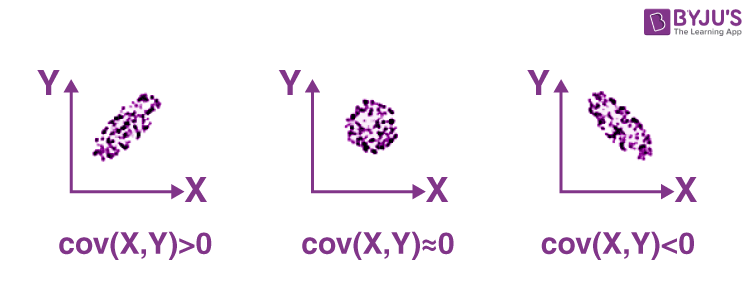
For forward-tilt elipse (left),
every point with large X deviation has large Y deviation.  
For the circle (center),
every point with large X deviation has tiny Y deviation, and vice-versa.

## Correlation vs Covariance 
There are similarities and differences.    
Correlation varies from -1 to +1.  
+ Positive cor gives a bottom-left to top-right diagonal.  
+ Negative cor gives a bottom-right to top-left diagonal.  
+ Zero cor implies independence.  

Covariance values can be anything.  
+ Positive off-diagonal cov gives a bottom-left to top-right diagonal.  
+ Negative off-diagonal cov gives a bottom-right to top-left diagonal.  
+ Zero covariance means statistical independence.  

Imagine data tight on the positive diagonal.  
The XY correlations are close to 1 because large X correlates to large Y.  
The XY covariance is large -- close to variance of X or of Y.  

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from numpy.random import normal  # random number generators
import matplotlib.pyplot as plt
import math

Blue: no covariance
 [[20.   0. ]
 [ 0.   0.1]]
Red: no covariance
 [[20  0]
 [ 0 20]]
Green: large negative covariance
 [[ 20.  -19.9]
 [-19.9  20. ]]


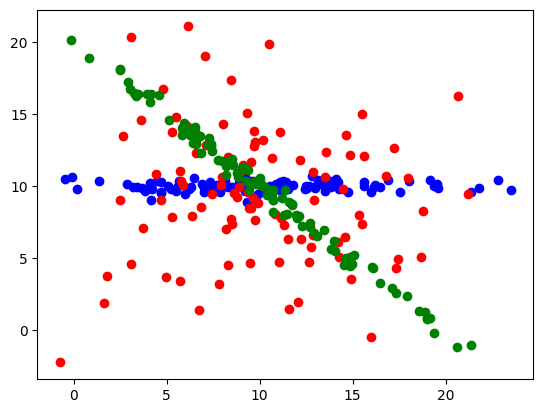

In [2]:
means = np.array([10,10])
N = 100
covB = np.array([[20, 0], [0, 0.1]]) # blue : high X variance
covR = np.array([[20, 0], [0, 20]]) # red : high X and Y variance, no covariance
covG = np.array([[20, -19.9], [-19.9, 20]])  # green : covariance close to variance
print('Blue: no covariance\n',covB)
print('Red: no covariance\n',covR)
print('Green: large negative covariance\n',covG)
dataB = multivariate_normal.rvs(means, covB, N)
dataR = multivariate_normal.rvs(means, covR, N)
dataG = multivariate_normal.rvs(means, covG, N)
plt.scatter(dataB[:,0],dataB[:,1],color='blue')
plt.scatter(dataR[:,0],dataR[:,1],color='red')
plt.scatter(dataG[:,0],dataG[:,1],color='green')
plt.show()

### Numpy transposes matrices automatically

Knowing this clears up lots of confusion!
See [StackOverflow](https://stackoverflow.com/questions/17428621/python-differentiating-between-row-and-column-vectors)  
* If A is a 2x3matrix, then AT=np.transpose(A) is a 3x2matrix.
* Thus, A.dot(AT) is a 2x2 matrix.
* But A.dot(A) does the same thing. Numpy does the transpose automatically as needed.

In fact, numpy vectors are not inherently row-vectors or column-vectors, just vectors.
So np.transpose(vector) is a no-op.

In [3]:
# Demonstrate that numpy does the transpose for you
mylist = [1,2,3]
myvector = np.array(mylist)
print("original=",myvector,"transpose=",np.transpose(myvector),
      "dot product:",myvector.dot(np.transpose(myvector)))
print("Same result without the transpose:",myvector.dot(myvector))

original= [1 2 3] transpose= [1 2 3] dot product: 14
Same result without the transpose: 14


### Covariance, implemented from scratch 
(only using numpy for matrix multiplication)  

We'll handle the easiest case: using 2 variables and 2x2 covariance matrix.  
The computation requires matrix inverse and matrix determinant.  
The computation gets harder at higher dimensions.  
In fact, the compute can be impossible (when matrix not positive semidefinite).  
So, we'll just implement the simple 2x2 case.  

In [4]:
def roll_matrix(a,b,c,d):  # return 2x2 array
    M = np.zeros((2,2))
    M[0,0] = a
    M[0,1] = b
    M[1,0] = c
    M[1,1] = d
    return M
def unroll_matrix(M):    # return matrix as tuple
    a = M[0,0]
    b = M[0,1]
    c = M[1,0]
    d = M[1,1]
    return a,b,c,d
def determinant(M):      # determinant of 2x2 matrix
    a,b,c,d = unroll_matrix(M)
    det = a*d - b*c
    return det
def inverse(M):          # inverse of 2x2 matrix (may not exist)
    det = determinant(M)
    if det==0:
        return None
    tup = unroll_matrix(M)
    a,b,c,d = tuple(t/det for t in tup) 
    IM = roll_matrix(d,-b,-c,a)
    return IM

In [5]:
A = roll_matrix(-5,-3,4,3)
print('A=\n',A)
print('det(A)=',determinant(A))
print('inv(A)\n',inverse(A))

A=
 [[-5. -3.]
 [ 4.  3.]]
det(A)= -3.0
inv(A)
 [[-1.         -1.        ]
 [ 1.33333333  1.66666667]]


mahalanobis_distance = $\sqrt{(X-\mu)\Sigma^{-1}(X-\mu)^{T}}$

In [6]:
# Use numpy for dot product = inner product = sum ai*bi.
def mahalanobis_distance_squared(X,means,cov):   # distance X from distribution, used by Gauss
    inv = inverse(cov) # inverse: 2x2 matrix
    dev = np.subtract(X,means) # X - mu elementwise vector subtraction
    prod = dev.dot(inv).dot(dev)   # (deviation)(inverse Sigma)(deviation)
    # actual distance is the sqrt of this
    return prod
def multivariate_gaussian_prob(X,means,cov):
    """Shapes X:1x2, means:1x2, covariance:2x2"""
    dimensionality = 2  # assumed
    exponent = dimensionality/2  # 1D data uses sqrt, 2D data uses no exponent
    det = determinant(cov) # determinant: scalar
    constant = 1/(math.sqrt(det)*(2*math.pi)**exponent) # scalar. At D=2, exp=1
    mds = mahalanobis_distance_squared(X,means,cov)
    exponent = (-1/2)*mds
    prob = constant * math.exp(exponent)
    return prob

### Test our results against scipy

In [8]:
from scipy.stats import multivariate_normal
# mean(X) = 5, mean(Y)=3
means = np.asarray( (5,3) )
# var(X) = 10, var(Y) = 1, cov(XY) = 3
covar = roll_matrix(10,3,3,1)
print(covar)
lib=multivariate_normal(mean=means, cov=covar)  # scipy

[[10.  3.]
 [ 3.  1.]]


In [9]:
X = np.asarray( (5,3) )   
print("Prob of point at dead center of multivariate normal")
print("The probability is high")
print("Our value:",multivariate_gaussian_prob(X,means,covar))
print("Lib value:",lib.pdf(X))

Prob of point at dead center of multivariate normal
The probability is high
Our value: 0.15915494309189535
Lib value: 0.1591549430918954


In [10]:
X = np.asarray( (6,3) ) 
print("Prop of point at Y center, off-center X")
print("High variance of X makes this likely")
print("Our value:",multivariate_gaussian_prob(X,means,covar))
print("Lib value:",lib.pdf(X))

Prop of point at Y center, off-center X
High variance of X makes this likely
Our value: 0.09653235263005391
Lib value: 0.09653235263005393


In [11]:
X = np.asarray( (5,4) )  
print("Prob of point at Y off-center, center X")
print("Low variance of Y makes this unlikely")
print("Our value:",multivariate_gaussian_prob(X,means,covar))
print("Lib value:",lib.pdf(X))

Prob of point at Y off-center, center X
Low variance of Y makes this unlikely
Our value: 0.0010723775711956546
Lib value: 0.0010723775711956479
